Based on my learnings from the Deep Learning Specialization offered by [deeplearning.ai](https://www.coursera.org/specializations/deep-learning).

In [1]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.python.framework import ops

import numpy as np
import math

from urllib import request
import gzip
import pickle

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# Loading the dataset

filename = [
["training_images","train-images-idx3-ubyte.gz"],
["test_images","t10k-images-idx3-ubyte.gz"],
["training_labels","train-labels-idx1-ubyte.gz"],
["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1])
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            temp_x = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
            mnist[name[0]] = temp_x.reshape(temp_x.shape[0], 28, 28, 1)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            temp_y = np.frombuffer(f.read(), np.uint8, offset=8)
            mnist[name[0]] = temp_y.reshape(1, temp_y.shape[0])
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def load_dataset():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

download_mnist()
save_mnist()

X_train_orig, Y_train_orig, X_test_orig, Y_test_orig = load_dataset()
num_classes = len(np.unique(Y_test_orig))

print ("X_train_orig shape: " + str(X_train_orig.shape))
print ("Y_train_orig shape: " + str(Y_train_orig.shape))
print ("X_test_orig shape: " + str(X_test_orig.shape))
print ("Y_test_orig shape: " + str(Y_test_orig.shape))

Download complete.
Save complete.
X_train_orig shape: (60000, 28, 28, 1)
Y_train_orig shape: (1, 60000)
X_test_orig shape: (10000, 28, 28, 1)
Y_test_orig shape: (1, 10000)


y = 9


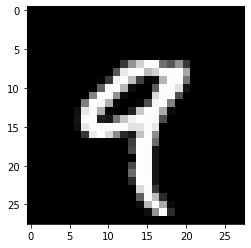

In [3]:
# Example of a picture
index = 4
plt.imshow((X_train_orig[index,:,:,:]).reshape(28,28))
print ("y = " + str(np.squeeze(Y_train_orig[:,index])))

In [4]:
# this function encodes true label vector with one-hot encoding

def convert_to_one_hot(Y_raw, C):
  """
    Encode true label vector with one-hot encoding
    
    Arguments:
    Y_raw -- true label vector, size: (1, number of training examples)
    C -- number of possible classes for labels

    Returns:
    Y -- one-hot encoded "true" label vector, shape: (number of classes, number of examples)
  """
    
  Y = np.eye(C)[Y_raw.reshape(-1)].T
  return Y

In [5]:
# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, num_classes).T
Y_test = convert_to_one_hot(Y_test_orig, num_classes).T

print ("number of label classes = " + str(num_classes))
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of label classes = 10
number of training examples = 60000
number of test examples = 10000
X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)
X_test shape: (10000, 28, 28, 1)
Y_test shape: (10000, 10)


In [6]:
# this function creates placeholders for input image X and output Y

def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels in the input image
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, shape: [None, n_H0, n_W0, n_C0]
    Y -- placeholder for the input labels, shape: [None, n_y]
    """

    X = tf.compat.v1.placeholder(tf.float32, (None, n_H0, n_W0, n_C0))
    Y = tf.compat.v1.placeholder(tf.float32, (None, n_y))
    
    return X, Y

In [7]:
# this function initilizes model parameters for the CNN

def initialize_parameters(n_C0):
    """
    Initializes weight parameters of the kernels/filters for convolutional layers in the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    n_C0 -- scalar, number of channels in the input image

    Returns:
    parameters -- dictionary of tensors containing W1, W2
    """
    
    W1 = tf.compat.v1.get_variable("W1", [4, 4, n_C0, 8], tf.float32, 
                                   tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform", seed = 0))
    W2 = tf.compat.v1.get_variable("W2", [2, 2, 8, 16], tf.float32, 
                                   tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform", seed = 0))

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [8]:
# this function implements forward propagation through all the layers

def forward_propagation(X, parameters, n_y):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Note that for simplicity and grading purposes, we'll hard-code some values
    such as the stride and kernel (filter) sizes. 
    Normally, functions should take these values as function parameters.
    
    Arguments:
    X -- input dataset placeholder, shape: (input size, number of examples)
    parameters -- dictionary containing model parameters "W1", "W2"
    n_y -- scalar, number of classes

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(input=X, filters=W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tf.nn.max_pool2d(input=A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')

    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(input=P1, filters=W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool2d(input=A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')

    # FLATTEN
    F = tf.compat.v1.layers.flatten(P2)

    # FULLY-CONNECTED without non-linear activation function
    # number of hidden units in the output layer corresponds to number of label classes
    Z3 = tf.compat.v1.layers.dense(F, n_y, activation=None)

    return Z3

In [9]:
# this function computes the cross-entropy cost

def compute_cost(Z3, Y):
    """
    Computes the softmax cross-entropy cost for multinomial classification
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), shape: (number of examples, number of classes)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    cost = tf.reduce_mean(input_tensor=tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = tf.stop_gradient( Y)))
    
    return cost

In [10]:
def random_mini_batches(X, Y, mini_batch_size = 500):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, shape: (m, Hi, Wi, Ci)
    Y -- true "label" vector, shape: (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    
    # Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Partition (shuffled_X, shuffled_Y)
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [11]:
# this function implements the 3-layer CNN model

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 500, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set
    Y_train -- test set
    X_test -- training set
    Y_test -- test set
    learning_rate -- determines step sizes during optimization, scalar
    num_epochs -- number of passes over the training set during optimization
    mini_batch_size -- the size of a mini batch    
    print_cost -- True to print the cost every 5 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model; used for making predictions
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                      
    costs = []                                        # To keep track of the cost
        

    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    # Initialize parameters
    parameters = initialize_parameters(n_C0)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters, n_y)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss = cost)
    
    # Initialize all the variables globally
    init = tf.compat.v1.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.compat.v1.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                """
                # Run the session to execute the optimizer and the cost
                # The feedict should contain a minibatch for (X,Y)
                """
                _ , temp_cost = sess.run(fetches=[optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every 5 epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(input=Z3, axis=1)
        correct_prediction = tf.equal(predict_op, tf.argmax(input=Y, axis=1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(input_tensor=tf.cast(correct_prediction, "float"))
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Instructions for updating:
Use keras.layers.Flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Dense instead.
Cost after epoch 0: 1.133566
Cost after epoch 5: 0.211377
Cost after epoch 10: 0.164185
Cost after epoch 15: 0.141699
Cost after epoch 20: 0.135304
Cost after epoch 25: 0.130344
Cost after epoch 30: 0.124696
Cost after epoch 35: 0.119544
Cost after epoch 40: 0.119500
Cost after epoch 45: 0.119305
Cost after epoch 50: 0.115165
Cost after epoch 55: 0.114399
Cost after epoch 60: 0.111381
Cost after epoch 65: 0.111593
Cost after epoch 70: 0.109206
Cost after epoch 75: 0.111440
Cost after epoch 80: 0.110954
Cost after epoch 85: 0.106052
Cost after epoch 90: 0.106815
Cost after epoch 95: 0.106092


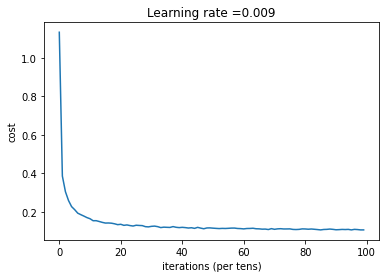

Train Accuracy: 0.9662
Test Accuracy: 0.9634


In [12]:
# training the model

_, _, parameters = model(X_train, Y_train, X_test, Y_test)